In [ ]:
#Fusion Model with Text and Images for Abnormality Detection
!pip install -q --upgrade keras-hub
!pip install -q --upgrade keras  # Upgrade to Keras 3.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.1/644.1 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 101.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [ ]:
import os

#os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

import json
import math
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import losses
from keras import ops
from keras import optimizers
#from keras.optimizers import schedules
from keras import metrics
from keras.applications.imagenet_utils import decode_predictions
import keras_hub

# Import tensorflow for [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) and its preprocessing functions
import tensorflow as tf
import tensorflow_datasets as tfds
from keras import layers
import tensorflow_hub as hub
import tensorflow.keras.layers
import tensorflow.keras.models
import tensorflow.keras.preprocessing.text
import tensorflow.keras.preprocessing.sequence
from tensorflow.keras.layers import Input, Dense, Concatenate, GlobalAveragePooling2D, Embedding, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
def plot_image_gallery(images, titles=None, num_cols=3, figsize=(6, 12)):
    num_images = len(images)
    print(num_images)
    images = np.asarray(images) / 255.0
    images = np.minimum(np.maximum(images, 0.0), 1.0)
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize, squeeze=False)
    axes = axes.flatten()  # Flatten in case the axes is a 2D array

    for i, ax in enumerate(axes):
        if i < num_images:
            # Plot the image
            ax.imshow(images[i])
            ax.axis("off")  # Remove axis
            if titles and len(titles) > i:
                ax.set_title(titles[i], fontsize=12)
        else:
            # Turn off the axis for any empty subplot
            ax.axis("off")

    plt.show()
    plt.close()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

def load_data(data_dir):
  image_files = []
  labels = []
  for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    print(class_name)
    if os.path.isdir(class_dir):
      for filename in os.listdir(class_dir):
        file_path = os.path.join(class_dir, filename)
        if filename.endswith(".jpg"):
          image_files.append(file_path)
          if(class_name == "Abnormal"):
            labels.append(1)
          else:
            labels.append(0)
          #labels.append(class_name)
        #elif filename.endswith(".txt"):
          #print(file_path)
          #text_files.append(file_path)
          #labels.append(class_name)

  return image_files, labels

def load_text(image_files):

  text_files = []
  for path in image_files:
    #image = tf.io.read_file(image_path)
    #img_count += 1
    #image = tf.image.decode_jpeg(image, channels=3)
    #image = tf.image.resize(image, [224, 224])  # Resize as needed
    #image = tf.cast(image, tf.float32) / 255.0  # Normalize
    text_path = path.replace(".jpg", ".txt")
    text_files.append(text_path)
  #print(text_path)
  return text_files

def preprocess_image(image_path):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [224, 224])  # Resize as needed
  image = tf.cast(image, tf.float32) / 255.0  # Normalize
  #text = text.to_tensor(default_value="UNK")  # Handle empty sequences
  return image

def preprocess_text(text_path):
  text = tf.io.read_file(text_path)
  return text



img_count = 0
text_count = 0
# Load and preprocess data
image_files, labels = load_data("/content/drive/MyDrive/CS230_Project/Dental_DB/Classify/Data/")
text_files = load_text(image_files)


image_dataset = tf.data.Dataset.from_tensor_slices(image_files)
image_dataset = image_dataset.map(preprocess_image)

text_dataset = tf.data.Dataset.from_tensor_slices(text_files)
text_dataset = text_dataset.map(preprocess_text)
text_processor = layers.TextVectorization(
    max_tokens=20000,
    output_sequence_length=100  # Pad sequences to a maximum length of 100
)
text_processor.adapt(text_dataset.map(lambda text: text))

label_dataset = tf.data.Dataset.from_tensor_slices(labels)


# Combine datasets
dataset = tf.data.Dataset.zip((image_dataset, text_dataset), label_dataset)

def preprocess_data(inputs, label):
    image, text = inputs
    processed_text = text_processor(text)
    return (image, processed_text), label  # Return as ((image, text), label)

def get_test_data(inputs, label):
    image, text = inputs
    #processed_text = text_processor(text)
    return image, label  # Return as ((image, text), label)






# Calculate the split sizes
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = int(0.1 * len(dataset))

# Shuffle the dataset
dataset = dataset.shuffle(buffer_size=len(dataset))

# Split the dataset
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size).take(test_size)

train_dataset = train_dataset.map(preprocess_data)
val_dataset = val_dataset.map(preprocess_data)
test_dataset = test_dataset.map(get_test_data)
print(len(test_dataset))
def format_data(inputs, label):
    # Create a dictionary with two labels, one for each output layer
    image, text = inputs
    return (image, text), (label, label)

# Apply the formatting function to your datasets
train_dataset = train_dataset.map(format_data)
val_dataset = val_dataset.map(format_data)
#for sample in test_dataset.take(1):
  #print(sample)
  #print(sample[0].shape)
#val_dataset = val_t_dataset.map(get_test_data)
#test_dataset = full_dataset.skip(train_size + val_size)
#test_dataset = test_dataset.map(preprocess_data)

print("Number of images:", img_count)
print("Number of texts:", text_count)
# Apply the combine_data function to your datasets
#train_dataset = train_dataset.map(lambda image, text, label: combine_data(image, text, label))
#val_dataset = val_dataset.map(lambda image, text, label: combine_data(image, text, label))
#val_dataset = test_dataset.skip(val_size)
#test_dataset = test_dataset.take(test_size)

Abnormal
Normal
100
Number of images: 0
Number of texts: 0


In [ ]:
train_dataset = train_dataset.batch(32)  # Adjust batch size as needed
val_dataset = val_dataset.batch(32)
test_dataset = test_dataset.batch(32)

In [ ]:
#def create_image_encoder():
 # #image_input = tf.keras.Input(shape=(224, 224, 3), name='image')
  #base_model = ResNet50(weights='imagenet', include_top=False)(image_input)
 # image_features = tf.keras.layers.GlobalAveragePooling2D()(base_model)
 # return Model(inputs=image_input, outputs=image_features, name = "Image_Encoder")

In [ ]:
def create_image_encoder():
  image_input = tf.keras.Input(shape=(224, 224, 3), name='image')
  base_model = keras.applications.ResNet50(weights='imagenet', include_top=False)(image_input)
  image_features = tf.keras.layers.GlobalAveragePooling2D()(base_model)


  image_features = tf.keras.layers.Dense(256, activation="relu")(image_features)
  image_features = tf.keras.layers.Dropout(0.3)(image_features)
  image_features = tf.keras.layers.Dense(128, activation="relu")(image_features)
  image_features = tf.keras.layers.Dropout(0.3)(image_features)
  image_features = tf.keras.layers.Dense(64, activation="relu")(image_features)
  image_features = tf.keras.layers.Dropout(0.3)(image_features)
  #output = tf.keras.layers.Dense(2, activation='softmax', name = "main_output")(image_features)
  return Model(inputs=image_input, outputs=image_features, name = "Image_Encoder")

In [ ]:
#def create_image_text_model():

text_input = tf.keras.Input(shape=(None,), name='text')

# Image processing layers
image_encoder = create_image_encoder()
image_input = image_encoder.input
image_features = image_encoder.output

# Text processing layers
text_features = tf.keras.layers.Embedding(10000, 64)(text_input)
text_features = tf.keras.layers.LSTM(64)(text_features)

# Concatenate image and text features
combined_features = tf.keras.layers.concatenate([image_features, text_features])
combined_features = tf.keras.layers.Dense(64, activation='relu')(combined_features)
compiled_features = tf.keras.layers.Dropout(0.3)(combined_features)
# Output layer
main_output = tf.keras.layers.Dense(1, activation='sigmoid', name = "main_output")(combined_features)

aux_output = tf.keras.layers.Dense(1, activation='sigmoid', name='image_only_output')(image_features)

# Create the model

model = tf.keras.Model(inputs=[image_input, text_input], outputs=[main_output, aux_output])
    #model._layers.append(image_encoder)  # Append model to _layers list.
    #model._layers[-1]._name = "Image_Encoder" # Assign layer the desired name.
    #return model

#model = create_image_text_model()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.compile(optimizer='adam', loss={ "main_output": "binary_crossentropy",
        "image_only_output": "binary_crossentropy",
    }, loss_weights={"main_output": 1.0, "image_only_output": 0.7}, metrics={'main_output': ['accuracy'], 'image_only_output': ['accuracy']}) # Provide a dictionary of metrics specifying metrics

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        524,544 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         32,896 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text (InputLayer)         │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │          8,256 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, None, 64)       │        640,000 │ text[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 64)             │         33,024 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128)            │              0 │ dropout_2[0][0],       │
│                           │                        │                │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 64)             │          8,256 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ main_output (Dense)       │ (None, 1)              │             65 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image_only_output (Dense) │ (None, 1)              │             65 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 24,834,818 (94.74 MB)

 Trainable params: 24,781,698 (94.53 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:

history = model.fit(train_dataset, epochs=20, validation_data=val_dataset)


In [ ]:
plt.plot(history.history['val_image_only_output_accuracy'])
plt.plot(history.history['val_main_output_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Image and Text', 'Image only'], loc='upper left')
plt.show()

In [ ]:
image_only_model = Model(inputs=image_input, outputs=aux_output)
image_only_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Get predictions
y_pred_prob = image_only_model.predict(test_dataset)

# Apply threshold
y_pred = np.where(y_pred_prob > 0.98, 1, 0)  # Adjust 0.6 to your desired threshold

# Calculate metrics

def custom_accuracy(y_true, y_pred):
    threshold = 0.99
    y_pred = tf.where(y_pred > threshold, 1.0, 0.0)
    return tf.keras.metrics.binary_accuracy(y_true, y_pred)
image_only_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', custom_accuracy])
image_only_model.evaluate(test_dataset)

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 535ms/step - accuracy: 0.3417 - custom_accuracy: 0.6583 - loss: 1.2012


[1.250860333442688, 0.3100000023841858, 0.6899999976158142]

In [ ]:
image_only_model = Model(inputs=image_input, outputs=aux_output)
image_only_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
image_only_model.evaluate(test_dataset)

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 534ms/step - accuracy: 0.3488 - loss: 1.2096


[1.2623919248580933, 0.3199999928474426]

In [ ]:
def create_image_model(image_text_model):
  image_encoder = image_text_model.image_encoder
  image_input = image_encoder.input
  image_features = image_encoder(image_input)
  x = tf.keras.layers.Dense(64, activation='relu')(image_features)
  x = tf.keras.layers.Dropout(0.3)(x)
  output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
  image_model = tf.keras.Model(inputs=image_input, outputs=output)
  return image_model

image_only_model = create_image_model(model)


AttributeError: 'Functional' object has no attribute 'image_encoder'

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 45s 335ms/step - accuracy: 0.5883 - loss: 0.7424 - val_accuracy: 0.5700 - val_loss: 42.1655
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 243ms/step - accuracy: 0.6485 - loss: 0.6453 - val_accuracy: 0.5700 - val_loss: 705.5398
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 239ms/step - accuracy: 0.6794 - loss: 0.6424 - val_accuracy: 0.6800 - val_loss: 42.9250
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 237ms/step - accuracy: 0.6717 - loss: 0.6124 - val_accuracy: 0.6100 - val_loss: 0.8123
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 242ms/step - accuracy: 0.6674 - loss: 0.5940 - val_accuracy: 0.6400 - val_loss: 0.6828
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 239ms/step - accuracy: 0.6705 - loss: 0.5711 - val_accuracy: 0.6800 - val_loss: 0.8633
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 240ms/step - accuracy: 0.6930 - loss: 0.5512 - val_accuracy: 0.7300 - val_loss: 0.6473
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 243ms/step - accuracy: 0.7184 - loss: 0.5267 - val_accurac

In [ ]:
image_only_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
image_only_model.fit(test_dataset, epochs=10)

Epoch 1/10


ValueError: Input 0 of layer "functional_19" is incompatible with the layer: expected shape=(None, 64), found shape=(None, 224, 224, 3)

In [ ]:
model.compile(
    loss={'main_output': 'binary_crossentropy', 'image_only_output': 'binary_crossentropy'},
    loss_weights={'main_output': 1.0, 'image_only_output': 0.5},
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"],
)

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8300 - loss: 0.7534

ValueError: Layer "functional_3" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'data:0' shape=(None, 224, 224, 3) dtype=float32>]

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model

#train_dataset = train_dataset.padded_batch(32, padded_shapes=([224, 224, 3], [100], [])) # padded_shapes is (image_shape, text_shape, label_shape)
#val_dataset = val_dataset.padded_batch(32, padded_shapes=([224, 224, 3], [100], []))  # padded_shapes is (image_shape, text_shape, label_shape)

train_image_data = []
train_text_data = []
train_labels = []
for image_batch, text_batch, label_batch in train_dataset:
    train_image_data.extend(image_batch.numpy())
    train_text_data.extend(text_batch.numpy())
    train_labels.extend(label_batch.numpy())

train_image_data = np.array(train_image_data)
train_text_data = np.array(train_text_data)
train_labels = np.array(train_labels)

# Repeat the same process for val_dataset
val_image_data = []
val_text_data = []
val_labels = []
for image_batch, text_batch, label_batch in val_dataset:
    val_image_data.extend(image_batch.numpy())
    val_text_data.extend(text_batch.numpy())
    val_labels.extend(label_batch.numpy())

val_image_data = np.array(val_image_data)
val_text_data = np.array(val_text_data)
val_labels = np.array(val_labels)


# Train the model
model.fit(
    {"image": train_image_data,
     "text": train_text_data},  # Provide both image and text inputs
    train_labels,  # Provide labels
    epochs=10,
    validation_data=(
        {"image": val_image_data,
         "text": val_text_data},  # Provide both image and text inputs for validation
        val_labels  # Provide validation labels
    )
)

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 201600, 57133
'y' sizes: 6074


In [ ]:
# Text Processing
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (without labels), then call adapt
train_text = train_text_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label


# retrieve a batch (of 32 texts and labels) from the dataset
# Each token is replaced by integer
text_batch, label_batch = next(iter(train_text_ds))
first_text, first_label = text_batch[0], label_batch[0]
print("first_text", first_text)
print("Label", train_text_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_text, first_label))


# Apply Text Vectorization to Train, Val
train_text_vect_ds = train_text_ds.map(vectorize_text)
val_text_vect_ds = val_text_ds.map(vectorize_text)
#test_ds = raw_test_ds.map(vectorize_text)


AUTOTUNE = tf.data.AUTOTUNE

train_text_vect_ds = train_text_vect_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_text_vect_ds = val_text_vect_ds.cache().prefetch(buffer_size=AUTOTUNE)
#test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

first_text tf.Tensor(b'Widening of follicular spaces number 1 and 16 hyperplastic follicle development', shape=(), dtype=string)
Label Abnormal
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[ 35,  13,  50,  82,   8,  57,  12,  66,  41,  48, 331,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  

In [ ]:
#Text Model
embedding_dim = 128
text_input = keras.Input(shape=(200,), dtype="int64")
text_embeddings = layers.Embedding(max_features, embedding_dim)(text_input)
text_features = LSTM(128)(text_embeddings)

#text_model = tf.keras.Sequential([
 ### layers.Dropout(0.2),
 # layers.GlobalAveragePooling1D(),
 # layers.Dropout(0.2),
  #layers.Dense(1, activation='sigmoid')])


In [ ]:
num_classes = len(train_ds.class_names)
print(num_classes)

resizing = keras.layers.Resizing(
    IMAGE_SIZE[0], IMAGE_SIZE[1], crop_to_aspect_ratio=True
)

def preprocess_inputs(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    # Staticly resize images as we only iterate the dataset once.
    return image, tf.one_hot(label, num_classes)

train_ds = train_ds.map(preprocess_inputs, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(preprocess_inputs, num_parallel_calls=AUTOTUNE)
#train_ds = train_ds.batch(BATCH_SIZE)



2


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32, 2)


In [ ]:
for image_batch, labels_batch in val_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32, 2)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Text Data Input

In [ ]:
image_input = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base_model = ResNet50(weights="imagenet", include_top=False)(image_input)
image_features = GlobalAveragePooling2D()(base_model)


#image_input = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
#image_base = keras_hub.models.ImageClassifier.from_preset("resnet_18_imagenet", num_classes=2)
#image_m = image_base (image_input)
#image_features = GlobalAveragePooling2D(image_m)
#image_model = keras.Model(image_input, image_features)



In [ ]:
def create_text_model():
  text_input = layers.Input(shape=(1,), dtype=tf.string)

In [ ]:
combined_features = layers.concatenate([image_features, text_features])
#x = layers.Dense(256, activation="relu")(combined_features)
#x = layers.Dropout(0.3)(x)
main_output = layers.Dense(1, activation="sigmoid", name="main_output")(x)#
image_output = layers.Dense(1, activation='sigmoid', name="image_only_output")(image_features)
model = keras.Model(inputs=[text_input, image_input], outputs=[main_output, image_output])

In [ ]:
model.compile(
    loss={'main_output': 'binary_crossentropy', 'image_only_output': 'binary_crossentropy'},
    loss_weights={'main_output': 1.0, 'image_only_output': 0.5},
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"],
)

In [ ]:
# Combine image and text datasets using tf.data.Dataset.zip()
train_dataset = tf.data.Dataset.zip((train_ds, train_text_vect_ds))
val_dataset = tf.data.Dataset.zip((val_ds, val_text_vect_ds))

# Modify the model.fit() call to use the combined datasets
# Pass inputs as a dictionary with keys matching the input layer names
history = model.fit(
    {'image_input': train_dataset.map(lambda image, text: image),
     'text_input': train_dataset.map(lambda image, text: text)},
    epochs=20,
    validation_data=({'image_input': val_dataset.map(lambda image, text: image),
                      'text_input': val_dataset.map(lambda image, text: text)})
)

ValueError: Unrecognized data type: x={'image_input': <_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>, 'text_input': <_MapDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>} (of type <class 'dict'>)

In [ ]:

# Combine image and text datasets using tf.data.Dataset.zip()
train_dataset = tf.data.Dataset.zip((train_ds, train_text_vect_ds))
val_dataset = tf.data.Dataset.zip((val_ds, val_text_vect_ds))

# Modify the model.fit() call to use the combined datasets
history = model.fit(train_dataset, epochs=20, validation_data=val_dataset)

Epoch 1/20


ValueError: Input 0 of layer "functional_11" is incompatible with the layer: expected shape=(None, 200), found shape=(None, 224, 224, 3)

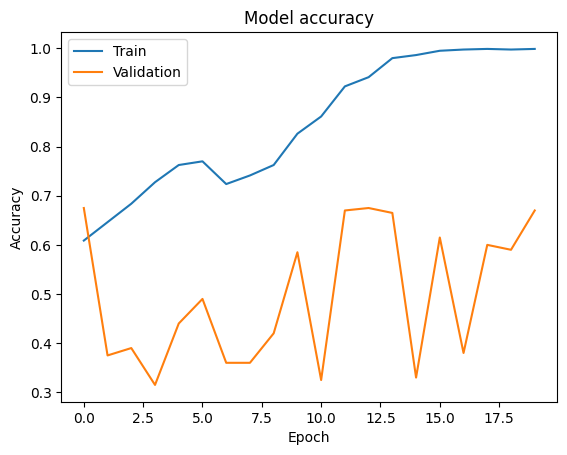

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

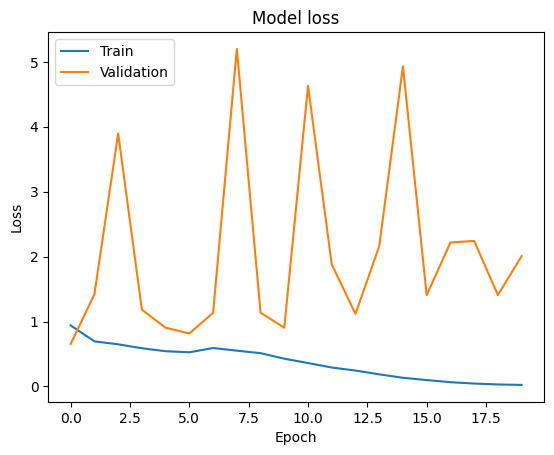

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
print(model.summary())

Preprocessor: "res_net_image_classifier_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ res_net_image_converter (ResNetImageConverter)                │                   Image size: (224, 224) │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "res_net_image_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                       ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)                   │ (None, None, None, 3)              │                   0 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ res_net_backbone (ResNetBackbone)             │ (None, None, None, 512)            │          11,186,112 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ pooler (GlobalAveragePooling2D)               │ (None, 512)                        │                   0 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ output_dropout (Dropout)                      │ (None, 512)                        │                   0 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ predictions (Dense)                           │ (None, 2)                          │               1,026 │
└───────────────────────────────────────────────┴────────────────────────────────────┴─────────────────────┘

 Total params: 33,542,216 (127.95 MB)

 Trainable params: 11,177,538 (42.64 MB)

 Non-trainable params: 9,600 (37.50 KB)

 Optimizer params: 22,355,078 (85.28 MB)

None
